# MNISTデータの読み込み

In [ ]:
import numpy as np
import tensorflow as tf
from keras.datasets import mnist # MNISTデータセットのインポート
from keras.utils import to_categorical

#--------------------------------------------------------------
# データセットのロード
# X：画像データ（28x28ピクセルの行列）、Y：正解ラベル（0～9の数値）
# train：モデルの学習用、test：学習に使わない評価・検証用
#--------------------------------------------------------------
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 変換後の形状を確認（例: 学習用なら (60000, 28, 28)）
print(X_train.shape)

# パラメータの設定
image_cols = 784  # 1データの要素数（28×28ピクセル = 784）
out_size = 10     # 分類するクラス数（数字の0～9に対応）

#--------------------
# 入力データの前処理
#--------------------
# 28x28の2次元画像を784要素の1次元配列（行ベクトル）に変換し、
# 0~255の輝度値を0~1の範囲に正規化（スケーリング）する
x_train = X_train.reshape(-1, image_cols) / 255
x_test = X_test.reshape(-1, image_cols) / 255

# 変換後の形状を確認（例: 学習用なら (60000, 784)）
print(x_train.shape)

#-------------------
# 出力データの前処理
#-------------------
y_train = to_categorical(Y_train, out_size)  # 学習用ラベルをone-hot表現へ変換
y_test = to_categorical(Y_test, out_size)    # 検証用ラベルをone-hot表現へ変換

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000, 784)


# シグモイド関数、損失関数の定義

- シグモイド関数 (Sigmoid Function)  
$\sigma(X) = \frac{1}{1 + e^{-X}}, \quad \sigma'(X) = \sigma(X)(1 - \sigma(X))$
  
- 損失関数 (二乗誤差)  
$E(Y) = \frac{1}{2}\sum\limits_{j}(y_j-t_j)^2, \quad E'(Y) = \sum\limits_{j}(y_j-t_j)$

In [ ]:
#import numpy as np

#---------------
# シグモイド関数
#---------------
class Sigmoid:
    def func_out(self, X):   # 関数の定義
        out = 1 / (1 + np.exp(-X))
        return out
    def func_diff(self, X):  # 関数の微分形
        out = 1 / (1 + np.exp(-X))
        return out*(1-out)

#----------
# 損失関数
#----------
class SSE:  # 二乗和誤差 (Sum of Squared Error)
    def loss_out(self, Y, T):
        E = np.sum((Y-T)**2)/2  # バッチ全体の損失の合計
        return E
    def loss_diff(self, Y, T):
        dE = Y -T
        return dE


#----------
# ReLu関数
#----------
class Relu:
    def __init__(self):
        self.mask = None
    def func_out(self, x):   # 関数の定義
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def func_diff(self, x):  # 関数の微分形
        result = np.ones((x.shape[0], x.shape[1]))
        result[self.mask] = 0
        return result

# 隠れ層、出力層のクラス定義

- 順伝播
  - $A = W\times [INPUT]$
  - $[OUTPUT] = \sigma (A)$

- 逆伝播
  - $\frac{\partial E}{\partial W} = [G\_INPUT]\odot\frac{\partial [OUTPUT]}{\partial A}\times [INPUT]^T$
  - $[G\_OUTPUT] = W^T\times[G\_INPUT]\odot\frac{\partial [OUTPUT]}{\partial A}$

- 推論
  - 順伝播と同様

- パラメータの更新
  - $W←W-\eta\frac{\partial E}{\partial W}$

In [ ]:
class InnerLayer:
    #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, W_row, W_column, batch_size, lr):
        # self.W = 0.05*np.random.randn(W_row, W_column+1)  # 重みの初期化（標準正規分布 * 0.05）            #--- バイアスを含めた場合 ---#
        self.W = np.random.randn(W_row, W_column+1)*np.sqrt(1.0 / W_column)  # 重みの初期化（Xavier）      #--- バイアスを含めた場合 ---#
        self.dW = np.zeros((W_row, W_column+1))           # W_row行W_column列の行列をゼロで初期化          #--- バイアスを含めた場合 ---#
        self.A = np.zeros((W_row,batch_size))           # W_row行batch_size列の行列をゼロで初期化
        self.Z_in = np.zeros((W_column+1,batch_size))     # W_column行batch_size列の行列をゼロで初期化     #--- バイアスを含めた場合 ---#
        self.Z_out = np.zeros((W_row,batch_size))       # W_row行batch_size列の行列をゼロで初期化
        self.DG_out = np.zeros((W_row,batch_size))      # W_row行batch_size列の行列をゼロで初期化
        self.eta = lr   # 学習係数
        self.Activate = Relu()  #活性化関数

    #--------
    # 順伝播
    #--------
    def forward(self, X):
        X = np.append(X, np.ones((1,X.shape[1])), axis=0)                                                  #--- バイアスを含めた場合 ---#
        self.Z_in = X               # 入力値を保存（逆伝播で使用）
        self.A = np.dot(self.W, X)  # 重み付き和の計算
        self.Z_out = self.Activate.func_out(self.A)  # 活性化関数の適用
        return self.Z_out

    #--------
    # 逆伝播
    #--------
    def backward(self, DG_in):
        DG_tmp = DG_in * self.Activate.func_diff(self.A)  # 入力誤差に活性化関数の微分を掛ける
        self.dW = np.dot(DG_tmp, self.Z_in.T)             # 重みの勾配を計算
        W_copy = np.copy(self.W)                                                                           #--- バイアスを含めた場合 ---#
        W_copy = np.delete(W_copy, -1, axis=1)                                                             #--- バイアスを含めた場合 ---#
        self.DG_out = np.dot(W_copy.T, DG_tmp)                                                             #--- バイアスを含めた場合 ---#
        # self.DG_out = np.dot(self.W.T,DG_tmp)            # 前の層へ渡す勾配を計算
        return self.DG_out

    #------------------------------------------------------------
    # 予測値出力（forwardと違い、内部パラメータの更新は行わない）
    #------------------------------------------------------------
    def predict(self, X):
        X = np.append(X, np.ones((1,X.shape[1])), axis=0)                                                  #--- バイアスを含めた場合 ---#
        A = np.dot(self.W, X)              # 重み付き和の計算
        Z_out = self.Activate.func_out(A)  # 活性化関数の適用
        return Z_out

    #-----------
    # 重みの更新
    #-----------
    def weightupdata(self):
        self.W -= self.eta*self.dW

#--------------------------------------------
# InnerLayerを継承して出力層を作る
# *** Layerと全く同じであるが、          ***
# *** 出力層にはsoftmax関数を使って      ***
# *** 出力を確率として出すこともあるため ***
# *** あえて別名でインスタンスを作成する ***
#--------------------------------------------
class OutLayer(InnerLayer):
    def __init__(self, W_row, W_column, batch_size, lr):
        # self.W = 0.05*np.random.randn(W_row, W_column+1)  # 重みの初期化（標準正規分布 * 0.05）            #--- バイアスを含めた場合 ---#
        self.W = np.random.randn(W_row, W_column+1)*np.sqrt(1.0 / W_column)  # 重みの初期化（Xavier）      #--- バイアスを含めた場合 ---#
        self.A = np.zeros((W_row,batch_size))           # W_row行batch_size列の行列をゼロで初期化
        self.Z_in = np.zeros((W_column+1,batch_size))     # W_column行batch_size列の行列をゼロで初期化     #--- バイアスを含めた場合 ---#
        self.Z_out = np.zeros((W_row,batch_size))       # W_row行batch_size列の行列をゼロで初期化
        self.DG_out = np.zeros((W_row,batch_size))      # W_row行batch_size列の行列をゼロで初期化
        self.eta = lr   # 学習係数
        self.Activate = Sigmoid()  #活性化関数                                                             #--- バイアスを含めた場合は出力層はシグモイド関数の方が良い ---#



# ニューラルネットワークのクラス定義
- 順伝播
  - 入力層→隠れ層1→隠れ層2→出力層
- 逆伝播
  - 損失関数→出力層→隠れ層2→隠れ層1（→入力層）
- パラメータ更新
  - 各層のパラメータ更新を実施

In [ ]:
class NeuralNetwork:
    #------------------
    # インスタンスの初期化
    #------------------
    def __init__(self, input_size, hidden_size, out_size, lr, batch_size):
        self.Layer1 = InnerLayer(hidden_size, input_size, batch_size, lr)
        self.Layer2 = InnerLayer(hidden_size, hidden_size, batch_size, lr)
        self.LastLayer = OutLayer(out_size, hidden_size, batch_size, lr)
        self.OUTPUT = np.zeros((out_size, batch_size))
        self.Loss = SSE()  # 損失関数
        self.E = 0         #損失

    #--------
    # 順伝播
    #--------
    def FORWARD(self, X):
        Layer1_out = self.Layer1.forward(X)               # 入力層→隠れ層1
        Layer2_out = self.Layer2.forward(Layer1_out)      # 隠れ層1→隠れ層2
        self.OUTPUT = self.LastLayer.forward(Layer2_out)  # 隠れ層2→出力層

    #--------
    # 逆伝播
    #--------
    def BACKWARD(self, T):
        self.E = self.Loss.loss_out(self.OUTPUT, T)/batch_size  # 損失値の平均の計算
        DG = self.Loss.loss_diff(self.OUTPUT, T)        # 損失関数の微分を算出
        DG_Lastlayer = self.LastLayer.backward(DG)      # 損失関数→出力層
        DG_Layer2 = self.Layer2.backward(DG_Lastlayer)  # 出力層→隠れ層2
        self.Layer1.backward(DG_Layer2)                 # 隠れ層2→隠れ層1

    #-----------
    # 予測値出力
    #-----------
    def PREDICT(self, X):
        Layer1_out = self.Layer1.predict(X)
        Layer2_out = self.Layer2.predict(Layer1_out)
        return self.LastLayer.predict(Layer2_out)

    #-----------
    # 重みの更新
    #-----------
    def WeightUpdata(self):
        self.Layer1.weightupdata()
        self.Layer2.weightupdata()
        self.LastLayer.weightupdata()

# MNISTの手書き文字識別に使うモデルのクラス定義

- 学習
   - 順伝播→逆伝播→パラメータ更新の順で処理を実施

- 推論
  - 入力から予測結果を出力
- 損失の取得
  - 学習時の損失を返す
- 精度の取得
  - ミニバッチでの正解率を返す

In [ ]:
class MNIST_MODEL:
    #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, input_size, hidden_size, out_size, lr, batch_size):
        self.NN = NeuralNetwork(input_size, hidden_size, out_size, lr, batch_size)  # ニューラルネットワークのインスタンスを作成

    #------
    # 学習
    #------
    def Train(self, X_data, T_data):
        self.NN.FORWARD(X_data)   # 順伝播
        self.NN.BACKWARD(T_data)  # 逆伝播
        self.NN.WeightUpdata()    # 重み更新

    #------
    # 推論
    #------
    def Predict(self, X):
        return self.NN.PREDICT(X)

    #-----------
    # 損失の取得
    #-----------
    def Get_Loss(self):
        return self.NN.E

    #-----------
    # 精度の取得
    #-----------
    def Get_Accuracy(self, X, T):
        P = self.NN.PREDICT(X)
        P = np.argmax(P, axis=0)  # 列方向に最大の値を持つ要素番号を返す(予測)
        T = np.argmax(T, axis=0)  # 列方向に最大の値を持つ要素番号を返す(正解)
        accuracy = np.sum(P == T) / X.shape[1]  # 予測と正解が一致する個数をデータ数で割る
        return accuracy

# 学習の実施、検証用データを用いた評価

1. MNISTモデルのインスタンスの生成
2. 学習の実施
   - 学習データと検証データのミニバッチを作成
   - 学習データのミニバッチで学習
3. 学習の成果を確認

Iteration 0:Loss = 1.360183
Iteration 1000:Loss = 0.064226
Iteration 2000:Loss = 0.024079
Iteration 3000:Loss = 0.014502
Iteration 4000:Loss = 0.007242
Iteration 5000:Loss = 0.020996
Iteration 6000:Loss = 0.021264
Iteration 7000:Loss = 0.012490
Iteration 8000:Loss = 0.026508
Iteration 9000:Loss = 0.017503
Accuracy =  97.45 %


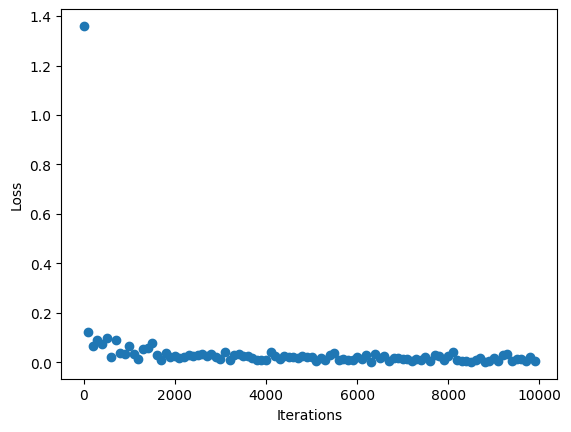

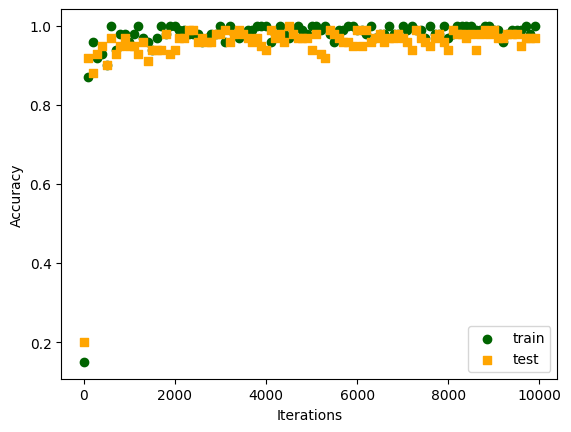

In [ ]:
import matplotlib.pyplot as plt

train_size = x_train.shape[0] # 学習データの総数 (60000)
test_size = x_test.shape[0]   # テストデータの総数 (10000)
input_size = x_train.shape[1] # 入力層のサイズ (784)
out_size = y_train.shape[1]   # 出力層のサイズ (10)
batch_size = 100              # ミニバッチのサイズ
hidden_size = 50              # 隠れ層のニューロン数
lr = 0.01                     # 学習係数 (Learning Rate)

# モデルのインスタンス化
MM = MNIST_MODEL(input_size, hidden_size, out_size, lr, batch_size)

# --- 学習の実行 ---
iters_num = 10000      # 繰り返しの回数
iters_list = []        # グラフ用：繰り返し回数の記録
Loss_list = []         # グラフ用：損失の記録
acc_list_train = []    # グラフ用：学習データの精度記録
acc_list_test = []     # グラフ用：テストデータの精度記録

#--------------
# モデルの学習
#--------------
for n in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)  # ミニバッチの作成（ランダムにデータを抽出）
    x_batch = x_train[batch_mask].T   # 列ベクトルにするための転置
    y_batch = y_train[batch_mask].T   # 列ベクトルにするための転置
    test_batch_mask = np.random.choice(test_size, batch_size)  # テストデータも同様にミニバッチの作成（ランダムにデータを抽出）
    x_test_batch = x_test[test_batch_mask].T  # 列ベクトルにするための転置
    y_test_batch = y_test[test_batch_mask].T  # 列ベクトルにするための転置

    # 学習の実施（順伝播・逆伝播・重み更新を一括実行）
    MM.Train(x_batch, y_batch)

    # batch_sizeごとに進捗の記録
    # 1000回ごとに進捗の表示
    if n % batch_size == 0:
        if n % 1000 == 0:
            print(f"Iteration {n}:Loss = {MM.Get_Loss():.6f}")
        iters_list.append(n)
        Loss_list.append(MM.Get_Loss())
        acc_list_train.append(MM.Get_Accuracy(x_batch, y_batch))
        acc_list_test.append(MM.Get_Accuracy(x_test_batch, y_test_batch))

#----------
# 最終評価
#----------
acc_cnt = 0
test_num = test_size

# 全てのテストデータに対して1件ずつ推論を行い、正解数をカウント
error_index = []   # 予測失敗したインデックスを記録
error_value = []   # 予測失敗した内容を記録
corr_index = []    # 正解したインデックスを記録
corr_value = []    # 正解した内容を記録
for i_test in range(test_num):
    x_test_new = x_test[i_test].reshape(-1,1)  # 1件のデータを列ベクトル化
    y_test_new = y_test[i_test].reshape(-1,1)
    answer = np.argmax(y_test[i_test])         # 正解の数値
    result = np.argmax(MM.Predict(x_test_new)) # モデルの予測数値
    if answer == result:
        acc_cnt += 1
        corr_index.append(i_test)
        corr_value.append(result)
    else:
        error_index.append(i_test)
        error_value.append(result)
print("Accuracy = ", acc_cnt/test_num * 100, "%")  # 最終的な正解率を表示


#--------------
# 結果の可視化
#--------------
# 損失の推移をプロット
plt.scatter(iters_list, Loss_list)
plt.xlabel("Iterations")  # 横軸：繰り返し回数
plt.ylabel("Loss")        # 縦軸：損失
plt.show()

# 精度の推移をプロット
plt.scatter(iters_list, acc_list_train, c='darkgreen', marker='o', label='train')
plt.scatter(iters_list, acc_list_test, c='orange', marker='s', label='test')
plt.xlabel("Iterations")  # 横軸：繰り返し回数
plt.ylabel("Accuracy")    # 縦軸：精度
plt.legend()
plt.show()

予測失敗値 : 2


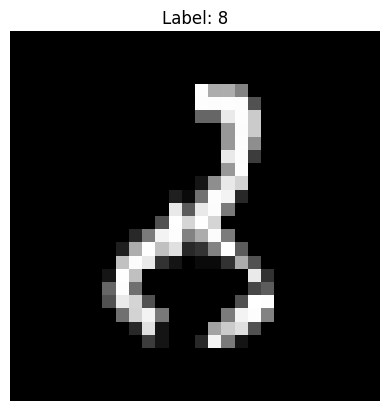

In [ ]:
#------------------------------
#--- 予測失敗した画像の表示 ---
#------------------------------

#print(error_index)   #失敗したインデックスの一覧を表示

idx_pos = np.random.choice(len(error_index))  # 0~(リストの個数)でランダムな数を取得
error_idx = error_index[idx_pos]              # ランダムに一つのインデックスを取得
error_val = error_value[idx_pos]              # 予測失敗した内容を取得
print("予測失敗値 :", error_val)

# 画像の描画
plt.imshow(X_test[error_idx], cmap='gray')           # 予測失敗したデータを白黒（gray）で表示
plt.title(f"Label: {np.argmax(y_test[error_idx])}")  # 正解ラベルを表示
plt.axis('off') # 目盛りを非表示にする
plt.show()

正解予測値 : 9


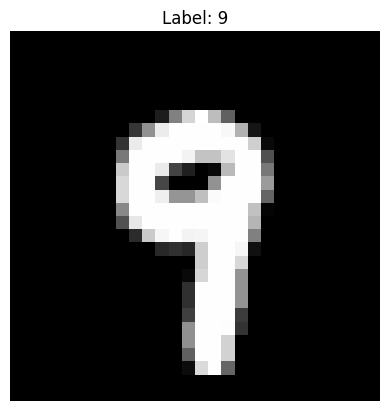

In [ ]:
#---------------------------
#--- 正解した画像の表示 ---
#--------------------------

#print(corr_index)   #失敗したインデックスの一覧を表示

idx_pos = np.random.choice(len(corr_index))  # 0~(リストの個数)でランダムな数を取得
corr_idx = corr_index[idx_pos]              # ランダムに一つのインデックスを取得
corr_val = corr_value[idx_pos]              # 予測失敗した内容を取得
print("正解予測値 :", corr_val)

# 画像の描画
plt.imshow(X_test[corr_idx], cmap='gray')           # 予測失敗したデータを白黒（gray）で表示
plt.title(f"Label: {np.argmax(y_test[corr_idx])}")  # 正解ラベルを表示
plt.axis('off') # 目盛りを非表示にする
plt.show()